<a href="https://colab.research.google.com/github/Harrisous/AIPI590-XAI-Adversial-Patch/blob/main/modified_adversarial_attacks_patches.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adversarial Attacks - Adversarial Patches
Haochen Li

This notebook is modified based on tutorial that was originally created by Phillip Lippe and modified by Dr. Brinnae Bent for use in "Emerging Trends in Explainable AI" at Duke University.

Click on the button below to open in Google Colab. You will need access to a GPU to run this code.


# Step 1: load dependencies & data

In [ ]:
## Standard libraries
import os
import json
import math
import time
import numpy as np
import scipy.linalg

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')  # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

# Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms

# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError:
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Data path and model path
DATASET_PATH = "../data"
CHECKPOINT_PATH = "../saved_models/tutorial10"

# Random seed setting
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

/tmp/ipython-input-2978915606.py:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf')  # For export
INFO:lightning_fabric.utilities.seed:Seed set to 42


Using device cuda:0


In [ ]:
import urllib.request
from urllib.error import HTTPError, URLError
import zipfile

# Github URL for dataset/model files
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial10/"
# Files to download
pretrained_files = [
    (DATASET_PATH, "TinyImageNet.zip"),
    (CHECKPOINT_PATH, "patches.zip")
]

# Create checkpoint path if it doesn't exist yet
os.makedirs(DATASET_PATH, exist_ok=True)
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for dir_name, file_name in pretrained_files:
    file_path = os.path.join(dir_name, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except (HTTPError, URLError) as e:
            print(
                f"Error downloading {file_url}.\n"
                "请尝试手动从作者GDrive链接下载，或联系开发者并提供此完整错误详情：\n", e
            )
            continue

        if file_name.endswith(".zip"):
            print("Unzipping file...")
            with zipfile.ZipFile(file_path, 'r') as zip_ref:
                zip_ref.extractall(os.path.dirname(file_path))
    else:
        print(f"{file_name} already exists in {dir_name}. Skipping download.")


TinyImageNet.zip already exists in ../data. Skipping download.
patches.zip already exists in ../saved_models/tutorial10. Skipping download.


# Step 2: Load pre-trained model & data set setup
- resnet34

In [ ]:
os.environ["TORCH_HOME"] = CHECKPOINT_PATH

# load ResNet34
pretrained_model = torchvision.models.resnet34(weights='IMAGENET1K_V1')
pretrained_model = pretrained_model.to(device)

# inference mode
pretrained_model.eval()
for param in pretrained_model.parameters():
    param.requires_grad = False

print("Model loaded and set to eval mode on", device)

Model loaded and set to eval mode on cuda:0


In [ ]:
# Mean and Std from ImageNet
NORM_MEAN = np.array([0.485, 0.456, 0.406])
NORM_STD = np.array([0.229, 0.224, 0.225])

# No resizing and center crop necessary as images are already preprocessed.
plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=NORM_MEAN, std=NORM_STD)
])

# Load dataset and create data loader
imagenet_path = os.path.join(DATASET_PATH, "TinyImageNet/")
assert os.path.isdir(imagenet_path), (
    f"Could not find the ImageNet dataset at expected path \"{imagenet_path}\". "
    f"Please ensure the dataset exists, or update DATASET_PATH."
)
dataset = torchvision.datasets.ImageFolder(root=imagenet_path, transform=plain_transforms)
data_loader = data.DataLoader(dataset, batch_size=32, shuffle=False, drop_last=False, num_workers=8)

# Load label names to interpret the label numbers 0 to 999）
with open(os.path.join(imagenet_path, "label_list.json"), "r") as f:
    label_names = json.load(f)

def get_label_index(lab_str):
    assert lab_str in label_names, f'Label "{lab_str}" not found. Check spelling.'
    return label_names.index(lab_str)

print("Sample label list:", label_names[:5])
print("Found", len(label_names), "labels in dataset.")


Sample label list: ['tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead']
Found 1000 labels in dataset.


The code from original notebook to measure the model using top1 and top5 accuracy

In [ ]:
def eval_model(dataset_loader, img_func=None):
    tp, tp_5, counter = 0., 0., 0.
    for imgs, labels in tqdm(dataset_loader, desc="Validating..."):
        imgs = imgs.to(device)
        labels = labels.to(device)
        if img_func is not None:
            imgs = img_func(imgs, labels)
        with torch.no_grad():
            preds = pretrained_model(imgs)
        tp += (preds.argmax(dim=-1) == labels).sum()
        tp_5 += (preds.topk(5, dim=-1)[1] == labels[...,None]).any(dim=-1).sum()
        counter += preds.shape[0]
    acc = tp.float().item()/counter
    top5 = tp_5.float().item()/counter
    print(f"Top-1 error: {(100.0 * (1 - acc)):4.2f}%")
    print(f"Top-5 error: {(100.0 * (1 - top5)):4.2f}%")
    return acc, top5



In [ ]:
_ = eval_model(data_loader)

Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Top-1 error: 19.38%
Top-5 error: 4.38%


# Step 3 Adversarial Patch Training

This patch transoform enables random postition + random scaling + random rotation to make the patch more robust to all kinds of changes.
Code blocks below generated by Perplexity, 14:30 - 16:30 11/1/2025

In [ ]:
import torchvision.transforms.functional as TF

def patch_transform(patch, img_shape, scale_range=(0.7,1.3), rot_range=(-45,45)):
    # random scaling
    scale = np.random.uniform(scale_range[0], scale_range[1])
    new_h = int(patch.shape[1] * scale)
    new_w = int(patch.shape[2] * scale)
    patch_scaled = TF.resize(patch, [new_h, new_w])
    # random 2D rotation
    angle = np.random.uniform(rot_range[0], rot_range[1])
    patch_rot = TF.rotate(patch_scaled, angle)
    return patch_rot

def place_patch(img, patch):
    # img: [B, 3, H, W], patch: [3, ph, pw]
    img = img.clone()
    for i in range(img.shape[0]):
        # apply random scaling and random 2D rotation
        cur_patch = patch_transform(patch, img[i].shape)
        h, w = cur_patch.shape[1], cur_patch.shape[2]
        # random position
        h_offset = np.random.randint(0, img.shape[2] - h)
        w_offset = np.random.randint(0, img.shape[3] - w)
        # add patch
        img[i,:,h_offset:h_offset+h, w_offset:w_offset+w] = cur_patch
    return img
# ignore below
# 更高级3D变换建议：可用 Kornia 或 OpenCV/torchvision 仿射+透视，但通常2D旋转和大扰动已足够
# 如需严肃3D旋转，可考虑 Kornia.geometry.transform.affine/warp_perspective，或自定义外部变换


In [ ]:
TENSOR_MEANS, TENSOR_STD = torch.FloatTensor(NORM_MEAN)[:,None,None], torch.FloatTensor(NORM_STD)[:,None,None]
def patch_forward(patch):
    # Map patch values from [-infty,infty] to ImageNet min and max
    patch = patch.to(TENSOR_MEANS.device)
    patch = (torch.tanh(patch) + 1 - 2 * TENSOR_MEANS) / (2 * TENSOR_STD)
    return patch

In [ ]:
def eval_patch(model, patch, val_loader, target_class):
    model.eval()
    tp, tp_5, counter = 0., 0., 0.
    with torch.no_grad():
        for img, img_labels in tqdm(val_loader, desc="Validating...", leave=False):
            # For stability, place the patch at 4 random locations per image, and average the performance
            for _ in range(4):
                patch_img = place_patch(img, patch)
                patch_img = patch_img.to(device)
                img_labels = img_labels.to(device)
                pred = model(patch_img)
                # In the accuracy calculation, we need to exclude the images that are of our target class
                # as we would not "fool" the model into predicting those
                tp += torch.logical_and(pred.argmax(dim=-1) == target_class, img_labels != target_class).sum()
                tp_5 += torch.logical_and((pred.topk(5, dim=-1)[1] == target_class).any(dim=-1), img_labels != target_class).sum()
                counter += (img_labels != target_class).sum()
    acc = tp/counter
    top5 = tp_5/counter
    return acc, top5

Actual training starts from here

In [ ]:
def patch_attack(model, target_class, patch_size=64, num_epochs=5, batch_size = 64):
    # Leave a small set of images out to check generalization
    # In most of our experiments, the performance on the hold-out data points
    # was as good as on the training set. Overfitting was little possible due
    # to the small size of the patches.
    train_set, val_set = torch.utils.data.random_split(dataset, [4500, 500])
    train_loader = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=8)
    val_loader = data.DataLoader(val_set, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=4)

    # Create parameter and optimizer
    if not isinstance(patch_size, tuple):
        patch_size = (patch_size, patch_size)
    patch = nn.Parameter(torch.zeros(3, patch_size[0], patch_size[1]), requires_grad=True)
    optimizer = torch.optim.SGD([patch], lr=1e-1, momentum=0.8)
    loss_module = nn.CrossEntropyLoss()

    # Training loop
    for epoch in range(num_epochs):
        t = tqdm(train_loader, leave=True)
        for img, _ in t:
            img = place_patch(img, patch)
            img = img.to(device)
            pred = model(img)
            labels = torch.zeros(img.shape[0], device=pred.device, dtype=torch.long).fill_(target_class)
            loss = loss_module(pred, labels)
            optimizer.zero_grad()
            loss.mean().backward()
            optimizer.step()
            t.set_description(f"Epoch {epoch}, Loss: {loss.item():4.2f}")

    # Final validation
    acc, top5 = eval_patch(model, patch, val_loader, target_class)

    return patch.data, {"acc": acc.item(), "top5": top5.item()}

In [ ]:
recreational_vehicle_idx = get_label_index("recreational vehicle")
patch, results = patch_attack(pretrained_model, target_class=recreational_vehicle_idx, patch_size=128, num_epochs=30)
print("Validation results:", results)

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Validating...:   0%|          | 0/8 [00:00<?, ?it/s]

Validation results: {'acc': 0.8450000286102295, 'top5': 0.9415000081062317}


# Step 4 Save and show patch

In [ ]:
torch.save(patch, os.path.join(CHECKPOINT_PATH, "recreational_vehicle_64_patch.pt"))

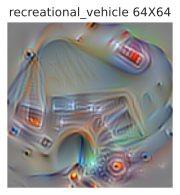

In [ ]:
def show_patch(patch, target_name):
    """
    patch: Tensor, shape [3, h, w]
    """
    # Apply tanh to compress the value range to [-1, 1], then normalize to [0, 1]
    patch_img = torch.tanh(patch).detach().cpu()
    # Map values to [0, 1] range for plt.imshow visualization
    patch_img = (patch_img + 1) / 2
    # Convert to [H, W, C] and display with numpy
    plt.figure(figsize=(3, 3))
    plt.imshow(patch_img.permute(1, 2, 0).numpy())
    plt.axis('off')
    plt.title(f"{target_name} 64X64")
    plt.show()

# Example: After training, call with obtained patch variable
show_patch(patch, 'recreational_vehicle')

Step 5 (innovation) Merge patch and user picture to make it less noticeable.

In [ ]:
from google.colab import files
from PIL import Image
import io

uploaded = files.upload()
fname = next(iter(uploaded))
background_img = Image.open(io.BytesIO(uploaded[fname])).convert('RGB')

Saving lighting.png to lighting.png


In [ ]:
import torch.nn.functional as F
import torchvision.transforms as T

def blend_patch_with_bg(patch, bg_img, alpha=0.5):
    """
    patch: Tensor [3, h, w]
    bg_img: PIL.Image，user uploaded background image
    alpha: float，merge ratio
    """
    patch_img = torch.tanh(patch).detach().cpu()
    patch_img = (patch_img + 1) / 2  # [0,1]
    # resize
    bg = T.ToTensor()(bg_img)
    bg = F.interpolate(bg.unsqueeze(0), size=patch_img.shape[1:], mode='bilinear', align_corners=False).squeeze(0)
    # merge
    blended = alpha * patch_img + (1 - alpha) * bg
    return blended

def batch_show_blended_patches(patch, bg_img, alphas=None):
    """
    display patch and background alpha merge result
    patch: Tensor [3, h, w], bg_img: PIL.Image
    alphas: list or None，if None, use [0.1, 0.2, ..., 0.9]
    """
    if alphas is None:
        alphas = [i/10 for i in range(1, 10)]  # [0.1, 0.2, ..., 0.9]
    n = len(alphas)
    plt.figure(figsize=(3*n, 3))
    for idx, alpha in enumerate(alphas):
        blended_patch = blend_patch_with_bg(patch, bg_img, alpha=alpha)
        plt.subplot(1, n, idx+1)
        plt.imshow(blended_patch.permute(1,2,0).numpy())
        plt.axis('off')
        plt.title(f'α={alpha:.1f}')
    plt.show()

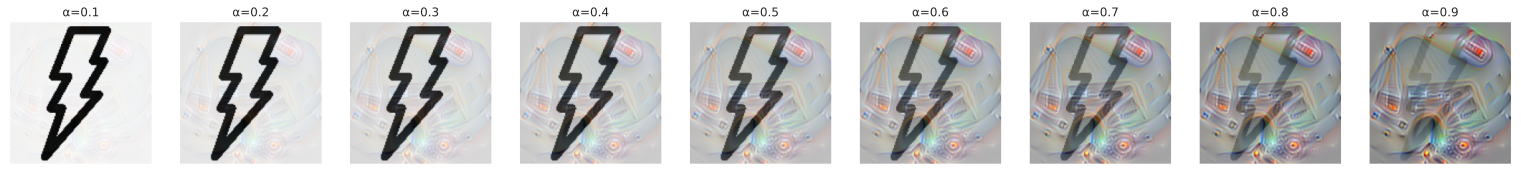

In [ ]:
batch_show_blended_patches(patch, background_img)

User can download all the merged results

In [ ]:
import os
import zipfile
from google.colab import files
import torchvision.transforms as T

def save_blended_images_with_patch_zip(patch, bg_img, alphas=None, out_prefix='blend_alpha_', tmp_dir='tmp_blend'):
    if alphas is None:
        alphas = [i/10 for i in range(1, 10)]  # [0.1, 0.2, ..., 0.9]
    # temp dir
    if not os.path.exists(tmp_dir):
        os.makedirs(tmp_dir)
    file_list = []

    # original batch is blend_alpha_00.png
    patch_img = torch.tanh(patch).detach().cpu()
    patch_img = (patch_img + 1) / 2
    img_np = (patch_img.permute(1,2,0).numpy() * 255).astype('uint8')
    out_file_patch = f"{out_prefix}00.png"
    out_path_patch = os.path.join(tmp_dir, out_file_patch)
    T.ToPILImage()(img_np).save(out_path_patch)
    file_list.append(out_path_patch)

    # save all alpha-merged pictures
    for alpha in alphas:
        blended = blend_patch_with_bg(patch, bg_img, alpha=alpha)
        img_np = (blended.permute(1,2,0).numpy() * 255).astype('uint8')
        out_file = f"{out_prefix}{int(alpha*100):02d}.png"
        out_path = os.path.join(tmp_dir, out_file)
        T.ToPILImage()(img_np).save(out_path)
        file_list.append(out_path)

    zip_path = f"{out_prefix}all.zip"
    with zipfile.ZipFile(zip_path, 'w') as zipf:
        for f in file_list:
            zipf.write(f, arcname=os.path.basename(f))

    files.download(zip_path)

In [ ]:
save_blended_images_with_patch_zip(patch, background_img)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## References

This tutorial was originally created by Phillip Lippe.
[![View notebooks on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial10/Adversarial_Attacks.ipynb)
[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial10/Adversarial_Attacks.ipynb)  

[1] Goodfellow, Ian J., Jonathon Shlens, and Christian Szegedy. "Explaining and harnessing adversarial examples." ICLR 2015.

[2] Hendrik Metzen, Jan, et al. "Universal adversarial perturbations against semantic image segmentation." Proceedings of the IEEE International Conference on Computer Vision. 2017.

[3] Anant Jain. "Breaking neural networks with adversarial attacks." [Blog post](https://towardsdatascience.com/breaking-neural-networks-with-adversarial-attacks-f4290a9a45aa) 2019.